In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.io import loadmat

from sklearn.decomposition import PCA

from palettable.colorbrewer.qualitative import Set1_9
colors = Set1_9.mpl_colors
cmap = Set1_9.mpl_colormap

%matplotlib inline

/Users/scott/anaconda/lib/python2.7/site-packages/mpl_toolkits/__init__.py:2: UserWarning: Module argparse was already imported from /Users/scott/anaconda/lib/python2.7/argparse.pyc, but /Users/scott/anaconda/lib/python2.7/site-packages is being added to sys.path
  __import__('pkg_resources').declare_namespace(__name__)


In [3]:
data_dir = "whole brain data Kato et al 2015"
zimmer_state_labels = \
    loadmat(os.path.join(
            data_dir, 
            "sevenStateColoring.mat"))
zimmer_data1 = \
    loadmat(os.path.join(
            data_dir, "wbdata", 
            "TS20140715e_lite-1_punc-31_NLS3_2eggs_56um_1mMTet_basal_1080s.mat"))

In [4]:
# Get the state sequence as labeled in Kato et al
zimmer_key = map(lambda x: str(x[0]), zimmer_state_labels["sevenStateColoring"]["key"][0,0][0])
zimmer_states1 = zimmer_state_labels["sevenStateColoring"]["dataset"][0,0]['stateTimeSeries'][0,0].ravel() - 1
# zimmer_cps = np.concatenate(([0], np.where(np.diff(zimmer_states1))[0]))
zimmer_cps = np.concatenate(([0], 1+np.where(np.diff(zimmer_states1))[0], [zimmer_states1.size-1]))
N_zimmer = zimmer_states1.max() + 1
# Get the calcium trace (corrected for bleaching)
tt = zimmer_data1["wbData"]['tv'][0,0]
dff = zimmer_data1["wbData"]['deltaFOverF'][0,0]
dff_bc = zimmer_data1["wbData"]['deltaFOverF_bc'][0,0]
dff_deriv = zimmer_data1["wbData"]['deltaFOverF_deriv'][0,0]

neuron_ids_array = zimmer_data1["wbData"]['NeuronIds'][0,0][0]
neuron_ids = map(lambda x: None if len(x[0])==0 else str(x[0][0][0]) , neuron_ids_array)



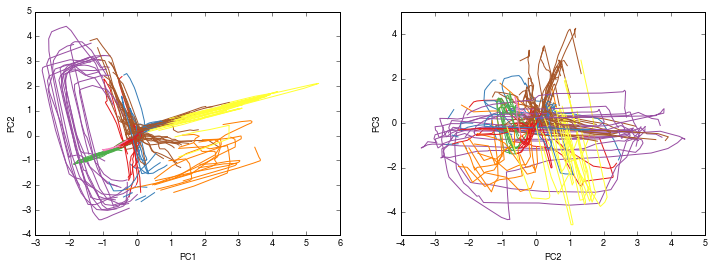

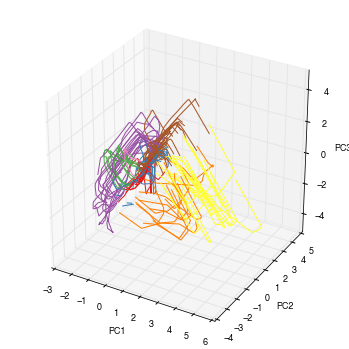

In [5]:
# Try to reproduce their plot of PC's over time
pca = PCA(n_components=10, whiten=True)
pca.fit(dff_deriv)
pca.explained_variance_ratio_

pca_traj = pca.transform(dff_deriv)
pcs = pca.components_.T

plt.figure(figsize=(12,4))
for cp_start, cp_stop in zip(zimmer_cps[:-1], zimmer_cps[1:]):
    plt.subplot(121)
    plt.plot(pca_traj[cp_start:cp_stop,0], 
             pca_traj[cp_start:cp_stop,1], 
             '-', color=colors[zimmer_states1[cp_start]])
    plt.subplot(122)
    plt.plot(pca_traj[cp_start:cp_stop,1], 
             pca_traj[cp_start:cp_stop,2], 
             '-', color=colors[zimmer_states1[cp_start]])
    
plt.subplot(121)
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(122)
plt.xlabel("PC2")
plt.ylabel("PC3")

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

for cp_start, cp_stop in zip(zimmer_cps[:-1], zimmer_cps[1:]):
    plt.plot(pca_traj[cp_start:cp_stop,0], 
             pca_traj[cp_start:cp_stop,1], 
             pca_traj[cp_start:cp_stop,2], 
             '-', color=colors[zimmer_states1[cp_start]])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

In [6]:
# Helper function to get empirical hyperparameters to initialize the SLDS
def _get_empirical_ar_params(train_datas, params, affine=True):
    """
    Estimate the parameters of an AR observation model
    by fitting a single AR model to the entire dataset.
    """
    from pybasicbayes.distributions import Regression

    assert isinstance(train_datas, list) and len(train_datas) > 0
    datadimension = train_datas[0].shape[1]
    assert params["nu_0"] > datadimension + 1

    if affine:
        xs = [np.hstack((td[:-1], np.ones((td.shape[0]-1,1)))) 
             for td in train_datas]
    else:
        xs = [td[:-1]for td in train_datas]

    ys = [td[1:]for td in train_datas]
        
    # Initialize the observation parameters
    obs_params = dict(nu_0=params["nu_0"],
                      S_0=params['S_0'],
                      M_0=params['M_0'],
                      K_0=params['K_0'],
                      affine=False)
    
    # Fit an AR model to the entire dataset
    obs_distn = Regression(**obs_params)
    obs_distn.max_likelihood(zip(xs,ys))

    # Use the inferred noise covariance as the prior mean
    # E_{IW}[S] = S_0 / (nu_0 - datadimension - 1)
    obs_params["S_0"] = obs_distn.sigma * (params["nu_0"] - datadimension - 1)

    return obs_params




In [68]:
# Now try fitting an SLDS to the calcium data

from pyhsmm.basic.distributions import Regression, Gaussian
from autoregressive.distributions import AutoRegression
from pyhsmm.util.text import progprint_xrange

from pyslds.models import WeakLimitStickyHDPHMMSLDS, HMMSLDS

data = dff_deriv

Nmax = 8          # number of latent discrete states
P = 3              # latent linear dynamics' dimension
T = data.shape[0]  # number of time bins
D = data.shape[1]  # number of neurons

dynamics_hypparams = dict(nu_0=P+2, S_0=np.eye(P), M_0=np.zeros((P,P+1)), K_0=np.eye(P+1))
dynamics_hypparams = _get_empirical_ar_params([pca_traj[:,:P]], dynamics_hypparams)
dynamics_distns = [
    Regression(
        A=np.hstack((0.99*np.eye(P), np.zeros((P,1)))), 
        sigma=np.eye(P),
        **dynamics_hypparams)
    for _ in xrange(Nmax)]

emission_distn = \
    Regression(
        A=np.hstack((pcs[:,:P], np.zeros((D,1)))), 
        sigma=np.eye(D),
        nu_0=D+3, S_0=np.eye(D), M_0=np.zeros((D,P+1)), K_0=np.eye(P+1))

init_dynamics_distns = [
    Gaussian(nu_0=P+2, sigma_0=3.*np.eye(P), mu_0=np.zeros(P), kappa_0=0.01)
    for _ in xrange(Nmax)]

# Sticky HDP-HMM over discrete states
model = WeakLimitStickyHDPHMMSLDS(
    dynamics_distns=dynamics_distns,
    emission_distns=emission_distn,
    init_dynamics_distns=init_dynamics_distns,
    kappa=100.,alpha=3.,gamma=3.,init_state_distn='uniform')


# Add the data and initialize the Gaussian stateseq with the PCA trajectories
inputs = np.ones((T,1))
model.add_data(data, inputs=inputs)
model.states_list[0].gaussian_states = pca_traj[:,:P]
model.states_list[0].resample_discrete_states()
model.resample_parameters()



In [69]:
import cPickle
results_fname = os.path.join("results", "2016_07_11_samples_K8.pkl")
if os.path.exists(results_fname):
    # Check for existing results
    with open(results_fname, "r") as f:
        model, stateseq_smpls, xs_smpls, sigma_xs_smpls, lls = cPickle.load(f)
        N_samples = len(stateseq_smpls)
else:
    # Fit the model with MCMC
    lls = []
    stateseq_smpls = []
    xs_smpls = []
    sigma_xs_smpls =[]
    N_samples = 1000
    for itr in progprint_xrange(N_samples):
        model.resample_model()
        lls.append(model.log_likelihood())
        stateseq_smpls.append(model.stateseqs[0].copy())
        
        # Get the smoothed continuous states
        model.states_list[0].E_step()
        xs = model.states_list[0].smoothed_mus
        sigma_xs = model.states_list[0].smoothed_sigmas
        xs_smpls.append(xs)
        sigma_xs_smpls.append(sigma_xs)
    
    
    results = (model, stateseq_smpls, xs_smpls, sigma_xs_smpls, lls)
    with open(results_fname, "w") as f:
        cPickle.dump(results, f, protocol=-1)



.........................  [   25/1000,    1.70sec avg, ETA 27:37 ]
.........................  [   50/1000,    1.71sec avg, ETA 27:06 ]
.........................  [   75/1000,    1.74sec avg, ETA 26:47 ]
.........................  [  100/1000,    1.72sec avg, ETA 25:46 ]
.........................  [  125/1000,    1.68sec avg, ETA 24:32 ]
.........................  [  150/1000,    1.67sec avg, ETA 23:38 ]
.........................  [  175/1000,    1.68sec avg, ETA 23:05 ]
.........................  [  200/1000,    1.67sec avg, ETA 22:12 ]
.........................  [  225/1000,    1.65sec avg, ETA 21:22 ]
.........................  [  250/1000,    1.64sec avg, ETA 20:34 ]
.........................  [  275/1000,    1.63sec avg, ETA 19:45 ]
.........................  [  300/1000,    1.63sec avg, ETA 18:58 ]
.........................  [  325/1000,    1.65sec avg, ETA 18:31 ]
.........................  [  350/1000,    1.64sec avg, ETA 17:48 ]
.........................  [  375/1000,    1.64s

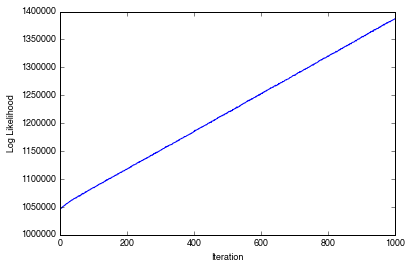

In [70]:
# Plot the log likelihood vs iteration. 
# Clearly we haven't burned in but already we see some reasonable states.
plt.figure()
plt.plot(lls)
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
plt.show()

In [71]:
# Helper functions to relabel state sequence by usage
def _get_labelset(labelss):
    import operator
    if isinstance(labelss,np.ndarray):
        labelset = np.unique(labelss)
        return set(labelset[~np.isnan(labelset)])
    else:
        return reduce(operator.or_,(_get_labelset(l) for l in labelss))

def _get_N(labelss):
    return int(max(_get_labelset(labelss)))+1

def relabel_by_permutation(l, perm):
    out = np.empty_like(l)
    good = ~np.isnan(l)
    out[good] = perm[l[good].astype('int32')]
    if np.isnan(l).any():
        out[~good] = np.nan
    return out

def relabel_by_usage(labelss, return_mapping=False, N=None):
    if isinstance(labelss,np.ndarray):
        backwards_compat = True
        labelss = [labelss]
    else:
        backwards_compat = False

    N = _get_N(labelss) if not N else N
    usages = sum(np.bincount(l[~np.isnan(l)].astype('int32'),minlength=N)
                 for l in labelss)
    perm = np.argsort(np.argsort(usages)[::-1])
    outs = [relabel_by_permutation(l,perm) for l in labelss]

    if backwards_compat:
        if return_mapping:
            return outs[0], perm
        else:
            return outs[0]
    else:
        if return_mapping:
            return outs, perm
        else:
            return outs

perm_stateseq_smpls, newlabels = relabel_by_usage(stateseq_smpls, return_mapping=True)
perm_dynamics_distns = [dynamics_distns[i] for i in np.argsort(newlabels)]

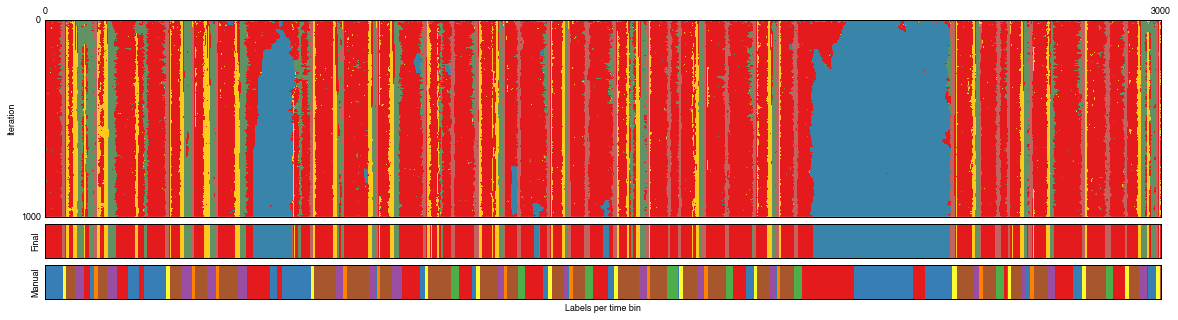

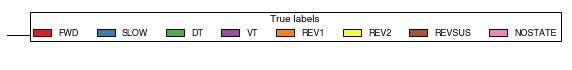

In [72]:
# Plot the true and inferred state sequences
plt_slice = (0, 3000)
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(7,1)

ax3 = fig.add_subplot(gs[-1])
ax1 = fig.add_subplot(gs[:-2])
ax2 = fig.add_subplot(gs[-2])

im = ax1.matshow(perm_stateseq_smpls, aspect='auto', cmap=cmap, vmin=0, vmax=Nmax-1)
ax1.autoscale(False)
ax1.set_xticks([])
ax1.set_yticks([0, N_samples])
ax1.set_ylabel("Iteration")
ax1.set_xlim(plt_slice)
ax1.set_xticks(plt_slice)

ax2.matshow(perm_stateseq_smpls[-1][None,:], aspect='auto', cmap=cmap, vmin=0, vmax=Nmax-1)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylabel("Final")
ax2.set_xlim(plt_slice)

ax3.matshow(zimmer_states1[None,:], aspect='auto', cmap=cmap, vmin=0, vmax=len(colors)-1)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_ylabel("Manual")
ax3.set_xlabel("Labels per time bin")
ax3.set_xlim(plt_slice)


# Make a legend
fig = plt.figure(figsize=(10,1))
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')

plt.yticks([])
plt.tick_params(axis='y',which='both', left='off', right='off', labelleft='off')

handles = []
for i,name in enumerate(zimmer_key):
    handles.append(ax.bar(0,0, color=cmap(float(i)/(len(colors)-1)), label=name)[0])
plt.legend(ncol=8, title="True labels")
plt.show()

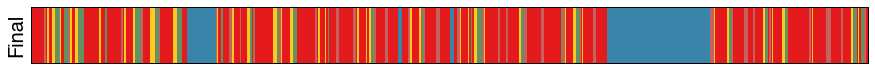

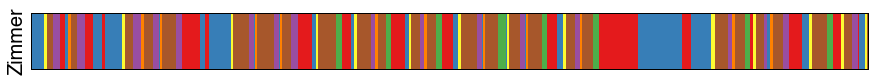

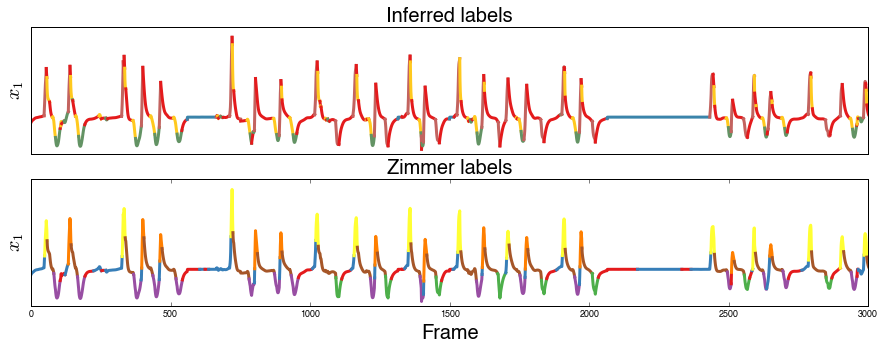

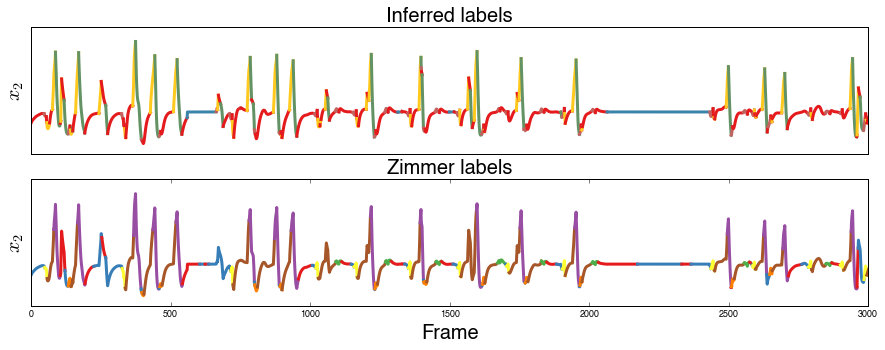

In [73]:
# View 1D state trajectories
states = model.states_list[0]
zs = perm_stateseq_smpls[-1]
xs, sigma_xs = xs_smpls[-1], sigma_xs_smpls[-1]
cps = np.concatenate(([0], 1+np.where(np.diff(zs))[0], [zs.size-1]))

plt.figure(figsize=(15,1))
ax2 = plt.subplot(111)
ax2.matshow(perm_stateseq_smpls[-1][None,:], aspect='auto', cmap=cmap, vmin=0, vmax=Nmax-1)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylabel("Final", fontsize=20)
ax2.set_xlim(plt_slice)

plt.figure(figsize=(15,1))
ax2 = plt.subplot(111)
ax2.matshow(zimmer_states1[None,:], aspect='auto', cmap=cmap, vmin=0, vmax=len(colors)-1)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylabel("Zimmer", fontsize=20)
ax2.set_xlim(plt_slice)

for xi in range(2):
    plt.figure(figsize=(15,5))

    # Inferred states
    ax1 = plt.subplot(211)
    for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
        ax1.plot(np.arange(cp_start, cp_stop+1),
                 xs[cp_start:cp_stop+1,xi], 
                 '-', lw=3,
                 color=cmap(zs[cp_start] / float(Nmax-1)))
        
    ax1.set_xlim(0,zs.size)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylabel("$x_%d$" % (xi+1), fontsize=20)
    ax1.set_title("Inferred labels", fontsize=20)

    # Zimmer states
    ax2 = plt.subplot(212)
    for cp_start, cp_stop in zip(zimmer_cps[:-1], zimmer_cps[1:]):
        plt.subplot(212)
        plt.plot(np.arange(cp_start,cp_stop+1), 
                 xs[cp_start:cp_stop+1,xi], 
                 '-', lw=3,
                 color=colors[zimmer_states1[cp_start]])
        
    ax2.set_xlim(0,zs.size)
    ax2.set_yticks([])
    ax2.set_xlabel("Frame", fontsize=20)
    ax2.set_ylabel("$x_%d$" % (xi+1), fontsize=20)
    ax2.set_title("Zimmer labels", fontsize=20)

    ax1.set_xlim(plt_slice)
    ax2.set_xlim(plt_slice)

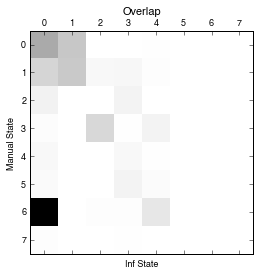

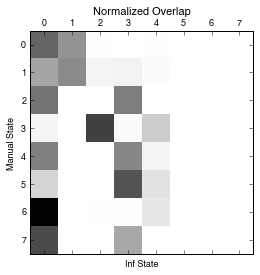

In [74]:
# Visualize the manual-inferred state overlap
N_zimmer = len(zimmer_key)
overlap = np.zeros((N_zimmer, Nmax))
inf_states1 = perm_stateseq_smpls[-1]
for z in range(N_zimmer):
    overlap[z] = np.bincount(inf_states1[zimmer_states1==z], minlength=Nmax)

normalized_overlap = overlap / (1e-3+overlap.sum(1, keepdims=True))

plt.matshow(overlap, cmap="Greys")
plt.xlabel("Inf State")
plt.ylabel("Manual State")
plt.title("Overlap")

plt.matshow(normalized_overlap, cmap="Greys")
plt.xlabel("Inf State")
plt.ylabel("Manual State")
plt.title("Normalized Overlap")

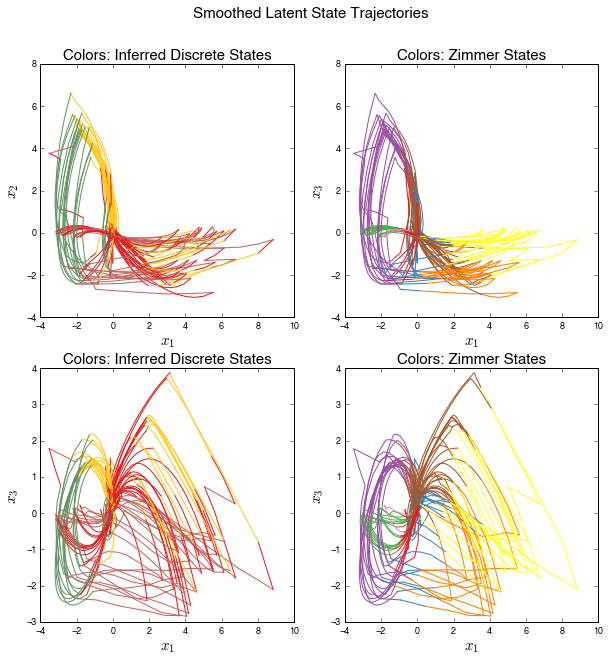

In [75]:
# Plot the inferred latent state sequence
fig = plt.figure(figsize=(10,10))

# Color denotes our inferred latent discrete state
for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
    # x2 vs x1
    plt.subplot(221)
    plt.plot(xs[cp_start:cp_stop+1,0], 
             xs[cp_start:cp_stop+1,1], 
             '-', color=cmap(zs[cp_start] / float(Nmax-1)))
    
    # x3 vs x1
    plt.subplot(223)
    plt.plot(xs[cp_start:cp_stop+1,0], 
             xs[cp_start:cp_stop+1,2], 
             '-', color=cmap(zs[cp_start] / float(Nmax-1)))

# Color denotes Zimmer state
for cp_start, cp_stop in zip(zimmer_cps[:-1], zimmer_cps[1:]):
    # x2 vs x1
    plt.subplot(222)
    plt.plot(xs[cp_start:cp_stop+1,0], 
             xs[cp_start:cp_stop+1,1], 
             '-', color=colors[zimmer_states1[cp_start]])
    

    # x3 vs x1
    plt.subplot(224)
    plt.plot(xs[cp_start:cp_stop+1,0], 
             xs[cp_start:cp_stop+1,2], 
             '-', color=colors[zimmer_states1[cp_start]])
    
plt.subplot(221)
plt.title("Colors: Inferred Discrete States", fontsize=15)
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15)

plt.subplot(222)
plt.title("Colors: Zimmer States", fontsize=15)
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_3$", fontsize=15)

plt.subplot(223)
plt.title("Colors: Inferred Discrete States", fontsize=15)
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_3$", fontsize=15)

plt.subplot(224)
plt.title("Colors: Zimmer States", fontsize=15)
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_3$", fontsize=15)

fig.suptitle("Smoothed Latent State Trajectories", fontsize=15)

plt.savefig("results/07_12_16_b/smoothed_trajectories")

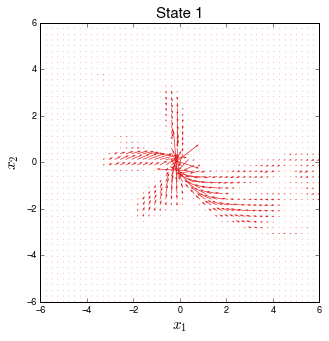

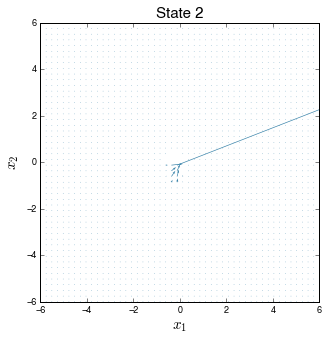

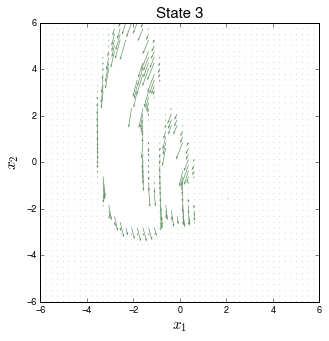

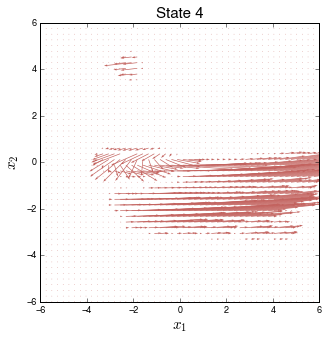

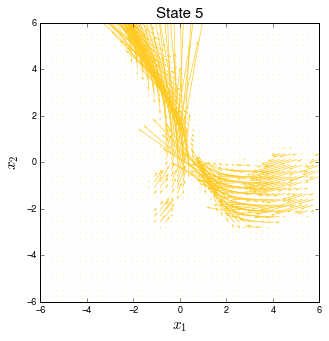

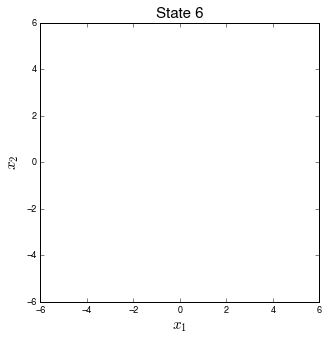

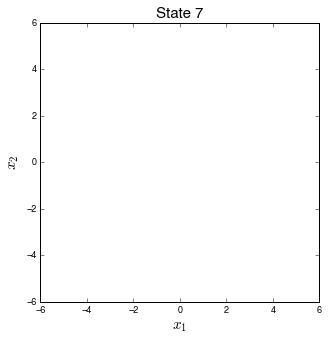

In [76]:
# Plot the vector field showing inferred (discrete-state-dependent)
# dynamics at each point in continuous latent space.
# Sum over time bins and smoothed continuous latent states.
# so that each point in continuous latent space is 
#    E_{z} E_x_t [A x_{t}]
#
# We would ideally sample over A as well, but to start, just take
# a single sample of A.
from scipy.stats import multivariate_normal
# zs = perm_stateseq_smpls[-1]
# xs = xs_smpls[-1]
# sigma_xs = sigma_xs_smpls[-1]
dds = perm_dynamics_distns

n_pts = 50
xmin, xmax = -6, 6
dx = dy = (xmax - xmin) / float(n_pts) 
XX, YY, ZZ = np.meshgrid(np.linspace(xmin,xmax,n_pts),
                         np.linspace(xmin,xmax,n_pts),
                         np.linspace(0,0,1))
xx, yy, zz = np.ravel(XX), np.ravel(YY), np.ravel(ZZ)
xyz = np.column_stack((xx, yy, zz))

# Make the plot for a single latent state
for ktoplot in range(8):
    plt.figure(figsize=(5,5))
#     plt.subplot(121)
    for kk in range(ktoplot,ktoplot+1):
        t_kk = np.where(zs == kk)[0]
        if len(t_kk) == 0:
            continue

        # Figure out where the dynamics take each point
        A, b = dds[kk].A[:,:P], dds[kk].A[:,P]
        d_xyz = xyz.dot(A.T) + b - xyz

        UU, VV = np.zeros(n_pts**2), np.zeros(n_pts**2)
        for t in t_kk:
            pr_x = multivariate_normal.pdf(xyz[:,:2], mean=xs[t][:2], cov=sigma_xs[t][:2,:2])
            UU += d_xyz[:,0] * pr_x * dx * dy
            VV += d_xyz[:,1] * pr_x * dx * dy

        UU /= len(t_kk)
        VV /= len(t_kk)

        UU = UU.reshape((n_pts, n_pts))
        VV = VV.reshape((n_pts, n_pts))

        # Threshold
        thr = np.percentile(UU.ravel(), 0.1)
        mask = np.bitwise_or(UU<thr, VV<thr)

        # Make the plot
        plt.quiver(XX[:,:,0], YY[:,:,0],
                   np.ma.masked_array(UU, mask=mask),
                   np.ma.masked_array(VV, mask=mask),
                   angles='xy',
                   scale=0.01,
                   color=cmap(kk / float(Nmax-1)))


        plt.xlabel("$x_1$", fontsize=15)
        plt.ylabel("$x_2$", fontsize=15)

    plt.xlim(xmin, xmax)
    plt.ylim(xmin, xmax)

    plt.xlabel("$x_1$", fontsize=15)
    plt.ylabel("$x_2$", fontsize=15)
    
    plt.title("State {}".format(kk+1), fontsize=15)

    plt.savefig("results/07_12_16_b/vector_field_{}.png".format(ktoplot))

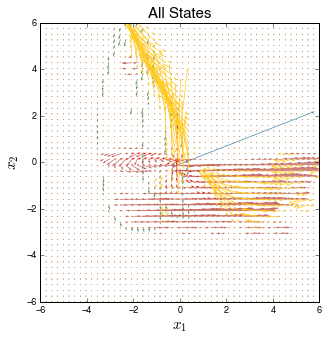

In [77]:
# Plot the vector field showing inferred (discrete-state-dependent)
# dynamics at each point in continuous latent space.
# Sum over time bins and smoothed continuous latent states.
# so that each point in continuous latent space is 
#    E_{z} E_x_t [A x_{t}]
#
# We would ideally sample over A as well, but to start, just take
# a single sample of A.
from scipy.stats import multivariate_normal
# zs = perm_stateseq_smpls[-1]
# xs = xs_smpls[-1]
# sigma_xs = sigma_xs_smpls[-1]
dds = perm_dynamics_distns

n_pts = 50
xmin, xmax = -6, 6
dx = dy = (xmax - xmin) / float(n_pts) 
XX, YY, ZZ = np.meshgrid(np.linspace(xmin,xmax,n_pts),
                         np.linspace(xmin,xmax,n_pts),
                         np.linspace(0,0,1))
xx, yy, zz = np.ravel(XX), np.ravel(YY), np.ravel(ZZ)
xyz = np.column_stack((xx, yy, zz))

# Make the plot for a single latent state
plt.figure(figsize=(5,5))
for kk in range(0,7):
    t_kk = np.where(zs == kk)[0]
    if len(t_kk) == 0:
        continue

    # Figure out where the dynamics take each point
    A, b = dds[kk].A[:,:P], dds[kk].A[:,P]
    d_xyz = xyz.dot(A.T) + b - xyz

    UU, VV = np.zeros(n_pts**2), np.zeros(n_pts**2)
    for t in t_kk:
        pr_x = multivariate_normal.pdf(xyz[:,:2], mean=xs[t][:2], cov=sigma_xs[t][:2,:2])
        UU += d_xyz[:,0] * pr_x * dx * dy
        VV += d_xyz[:,1] * pr_x * dx * dy

    UU /= len(t_kk)
    VV /= len(t_kk)

    UU = UU.reshape((n_pts, n_pts))
    VV = VV.reshape((n_pts, n_pts))

    # Threshold
    thr = np.percentile(UU.ravel(), 0.1)
    mask = np.bitwise_or(UU<thr, VV<thr)

    # Make the plot
    plt.quiver(XX[:,:,0], YY[:,:,0],
               np.ma.masked_array(UU, mask=mask),
               np.ma.masked_array(VV, mask=mask),
               angles='xy',
               scale=0.03,
               color=cmap(kk / float(Nmax-1)))


    plt.xlabel("$x_1$", fontsize=15)
    plt.ylabel("$x_2$", fontsize=15)

plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)

plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15)

plt.title("All States", fontsize=15)

plt.savefig("results/07_12_16_b/vector_field_all.png")

In [33]:
# Information form marginalization
from scipy.linalg import solve_triangular
def natural_predict(J, h, J11, J12, J22, h1, h2, logZ):
    # convert from natural parameter to the usual J definitions
#     J, J11, J12, J22 = -2*J, -2*J11, -J12, -2*J22

    L = np.linalg.cholesky(J + J11)
    v = solve_triangular(L, h + h1)
    lognorm = 1./2*np.dot(v,v) - np.sum(np.log(np.diag(L)))
    h_predict = h2 - np.dot(J12.T, solve_triangular(L, v, trans='T'))

    temp = solve_triangular(L, J12)
    J_predict = J22 - np.dot(temp.T, temp)

    assert np.all(np.linalg.eigvals(J_predict) > 0)

    return (J_predict, h_predict), lognorm + logZ

# Simple model:
# x ~ N(0,vx)
# y|x ~ N(ax+b, vy) 
#     \propto exp(-1/2/vy (y-ax-b)**2) 
#     =       exp(-1/2/vy (y**2 -2yax + ax**2 -2yb +2axb +b**2))
#     =       exp(-1/2 [x, y] [[ a**2/vy -a/vy]] [x] + [-ab, b][x] )
#                             [[-a/vy     1/vy]] [y]           [y] )
#
# Thus
# 
# p(x,y) \propto exp(-1/2 ([x, y] [[ 1/vy+1/vx -1/vy]]  [x] + [-ab, b][x] )
#                         (       [[-1/vy       1/vy]]  [y]           [y] )
#
# and if vx = vy = 1 and a =1 and b = 0,
# 
# Sigma = [[1, 1],   mu = [0]
#          [1, 2]]        [0]
#
# so p(y) = N(0,a**2 vx+vy), as expected, and Jy = 0.5
mux = np.array([0])
vx  = np.array([[1.]])
a = 2.0
b = 1.0
vy = 1.0

Jx  = np.linalg.inv(vx)
hx  = Jx.dot(mux)
J11 = np.array([[ a**2 / vy]])
J12 = np.array([[-a    / vy]])
J22 = np.array([[ 1.   / vy]])
h1  = np.array([-a*b])
h2  = np.array([b])

(Jy, hy), logZ = natural_predict(Jx, hx, J11, J12, J22, h1, h2, 0)
Sigmay = np.linalg.inv(Jy)
muy = np.dot(Sigmay, hy)
print "mu y: ", muy, "\tSigma y: ", Sigmay

print "Expected"
print "mu y: ", a*mux + b, "\tSigma y: ", a**2 * vx + vy

mu y:  [ 1.] 	Sigma y:  [[ 5.]]
Expected
mu y:  [ 1.] 	Sigma y:  [[ 5.]]
